<a href="https://colab.research.google.com/github/bongkyunSON/Deep_Leaning/blob/main/Prophet_case15_221211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Forcast using FbProphet

To learn more about Fb Prophet, please refer to https://www.facebook.com/gpa/facebook-protect

Data:
This dataset is from a UK retailer and can be downloaded from Kaggle. The dataset ranges from 2008 to 2011.

Desciption of variables:
* InvoiceDate- Date and time of the purchase.
* InvoiceNo - Invoice identification number.
* StockCode- Stock code for the product.
* Description - Brief description of the product.
* Quantity - Quantity of items purchased.
* UnitPrice - Unit price for a given product in Pounds Sterling.
* CurtomerID - ID of the customer making the purchase.
* Country - Country where the purchase was made.

In [1]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/prophet_강의/data/sales_data.csv', encoding='latin-1')

In [3]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [4]:
print('Features:', df.shape[1], ';', 'Entries:', df.shape[0])

Features: 8 ; Entries: 541909


In [5]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
    number_of_cells = df.count(axis=0, level=None, numeric_only=False)
    print('Total number of cells the datafile has: \n' + str(number_of_cells))
    print('\n')
    print('Printing descriptive statistics...\n\n', df.describe())

In [6]:
# check total number of cells, first few rows, and descriptive stats 
def _trans_date_time(df):
    df.index = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)
    df.drop('InvoiceDate', axis=1, inplace=True)
    return df

In [7]:
_trans_date_time(df) # don't run the function multiple times, it'll casue an error

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France


As we can see, this datafile is not in the correct fbProphet format. We need some work to preapre it in the correct format. 

In [8]:
# then, we need to check for missing values, especially if that's too high, we'll need to take care of it
(df.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

CustomerID     0.249267
Description    0.002683
InvoiceNo      0.000000
StockCode      0.000000
Quantity       0.000000
UnitPrice      0.000000
Country        0.000000
dtype: float64

We see that we've almost 25% of missing customer ID present. Because our dataset has more than 500k instances, we can get rid of the missing inputs without hurting  our analysis much.

In [9]:
# First make a copy of the original data and drop missing values from the new datafile
df2 = df.copy()
df2.dropna(axis = 0, inplace =True)
df2.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


In [10]:
# check for missing values back again
# then, we need to check for missing values, especially if that's too high, we'll need to take care of it
(df2.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

Good news! we got rid of all missing values

In [11]:
# check the info for the new dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 406829 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   UnitPrice    406829 non-null  float64
 5   CustomerID   406829 non-null  float64
 6   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 24.8+ MB


We see that almost 100k instances have been deleted. Let's continue working with the new datafile. We'll create a new feature (column) for our time series analysis.

In [12]:
# Before we go any further, we need to fix one more thing. Because quantity can't 
# be zero, any quantity = 0 means that must be an error. Thus, we'll drop all rows with quantity = 0

df2 = df2[df2.Quantity > 0]

In [13]:
(df2['UnitPrice'] == 0).sum()

40

We see that 40 rows have unit price = 0. Again, unit price = 0 does not make sense. This must be an error and we need to take care of this like Quantity before.

In [14]:
df2 = df2[df2.UnitPrice > 0]

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397884 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   UnitPrice    397884 non-null  float64
 5   CustomerID   397884 non-null  float64
 6   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [16]:
# Now, let's calculate the new column that will show the total amount spent on a 
# particluar day on a specific product
df2['TotalAmount'] = df2['Quantity'] * df2['UnitPrice']

In [17]:
# check the file again
df2

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalAmount
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,10.20
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,12.60
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,16.60


Now, as you can see, we have data from the same day for different products, that a single customer may have purchased. For time series analysis, we need to do some work to prepare our dataset. 
let's create some features that will be useful for timeseries analysis.



In [18]:
 
# creating new features to help with the Time Series Analysis
# to learn more the following conversion, check out the link below-
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.year.html

df2["Year"] = df2.index.year 
df2["Quarter"] = df2.index.quarter
df2["Month"] = df2.index.month
df2["Week"] = df2.index.week
df2["Weekday"] = df2.index.weekday
df2["Day"] = df2.index.day
df2["Dayofyear"] = df2.index.dayofyear
df2["Date"] = pd.DatetimeIndex(df2.index).date

In [19]:
# Let's have a quick pick at our data including some descriptive stats
df2

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalAmount,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
InvoiceDate,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,10.20,2011,4,12,49,4,9,343,2011-12-09
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,12.60,2011,4,12,49,4,9,343,2011-12-09
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,16.60,2011,4,12,49,4,9,343,2011-12-09


In [20]:
# create vector with all grouping variables and use it for grouping Quantity and totalAmount
group_ = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day","StockCode"]

# now, group other variables using the above vector, we generate a new dataframe as df3
# where we group quantity and totalamount based on the group_ vector 
df3 = pd.DataFrame(df2.groupby(group_).Quantity.sum(), columns=["Quantity"])

# now let's also group the total amount column
df3["TotalAmount"] = df2.groupby(group_).TotalAmount.sum()
df3 = df3.reset_index()
df3

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,TotalAmount
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,15044B,1,2.95
4,2010-12-01,2010,4,12,48,2,335,1,15056BL,20,113.00
...,...,...,...,...,...,...,...,...,...,...,...
222365,2011-12-09,2011,4,12,49,4,343,9,85099C,10,17.90
222366,2011-12-09,2011,4,12,49,4,343,9,85123A,1,2.95
222367,2011-12-09,2011,4,12,49,4,343,9,85152,48,88.80
222368,2011-12-09,2011,4,12,49,4,343,9,85173,12,9.48


In [21]:
# Let's check the descriptive information for both variables
df3.loc[:, ["Quantity", "TotalAmount"]].describe()

,Quantity,TotalAmount
count,222370.00000,222370.000000
mean,23.23970,40.074686
std,241.60083,418.479825
min,1.00000,0.001000
25%,3.00000,6.800000
50%,9.00000,15.800000
75%,24.00000,34.000000
max,80995.00000,168469.600000


In [22]:
## function to Plot the prepared stock data

def _fig_plot(df, X, Y):
    ''' Function plots the data. requires to provide dataframe in the
    format of date as ds, observation as y, Preset other variables e.g., axis name
    '''
    df.plot(x = X, y = Y, figsize=Figsize, label = Label)
    plt.xlabel(xAxisLabel, fontsize = 16)
    plt.ylabel(yAxisLabel, fontsize = 16)
    plt.legend()
    plt.title(Title, fontsize = 20)
    ax = plt.gca().get_xaxis()


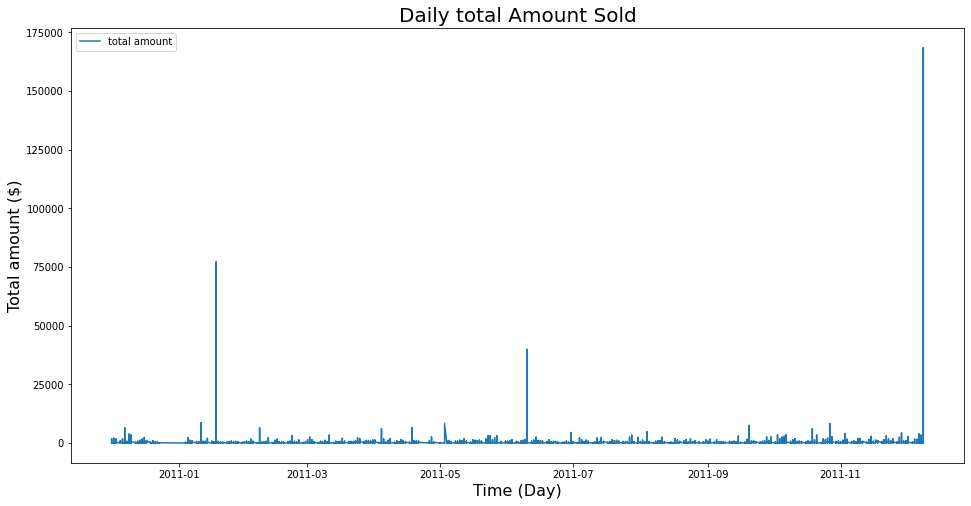

In [23]:
# provide variable names and other required inputs to plot using the function
X = 'Date'
Y = 'TotalAmount'
Label = "total amount"
Figsize = (16,8)
Title = "Daily total Amount Sold"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total amount ($)'
_fig_plot(df3, X, Y)

The plot clearly shows that we have some outliers in our dataset. Let's handle those first bedore proceeding further

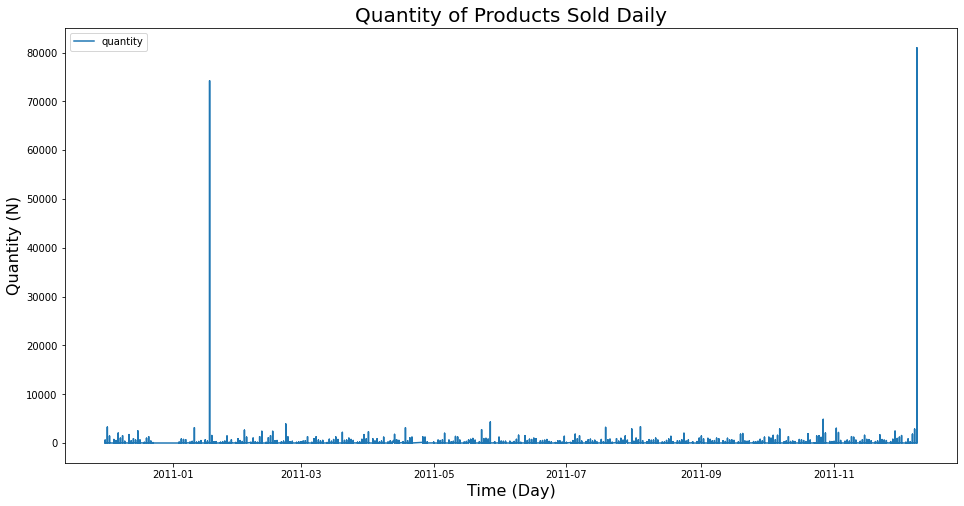

In [24]:
# provide variable names and other required inputs to plot using the function
X = 'Date'
Y = 'Quantity'
Label = "quantity"
Figsize = (16,8)
Title = "Quantity of Products Sold Daily"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Quantity (N)'
_fig_plot(df3, X, Y)

We see that both quantity and total amount has some outliers and need to be taken care of.

In [25]:
# identifying drop points based on quantile 1% and 99% for the amounttotal column
low_amount = df3.TotalAmount.quantile(0.01)
high_amount = df3.TotalAmount.quantile(0.99)
print((low_amount, high_amount))

(0.78, 380.8247999999998)


In [26]:
# identifying drop points for the Quantity column
low_quantity = df3.Quantity.quantile(0.01)
high_quantity = df3.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 225.0)


In [27]:
samples = df3.shape[0]
print(samples)

222370


In [28]:
# Now, let's select entries bigger than the low quantity value and lower than
# the high quantity value to take care of those outliers and same for the total amount spent column
df3 = df3.loc[(df3.Quantity >= low_amount) & (df3.Quantity <= high_amount)]
df3 = df3.loc[(df3.TotalAmount >= low_amount) & (df3.TotalAmount <= high_amount)]

In [29]:
# check how many rows we dropped
print('Dropped number of rows: ', (samples - df3.shape[0]), 'Current sample size: ', df3.shape[0])

Dropped number of rows:  4808 Current sample size:  217562


In [30]:
# Let's finanlize the data for time series prediction
# group the total amount by dates and convert date to a panda date-time format 
df4 = df3.groupby('Date',as_index=False)['TotalAmount'].sum() # grouping
df4['Date'] = pd.to_datetime(df4['Date'], format="%Y-%m-%d") # converting to datetime

In [31]:
df4

,Date,TotalAmount
0,2010-12-01,32068.29
1,2010-12-02,34682.29
2,2010-12-03,19411.87
3,2010-12-05,29226.82
4,2010-12-06,23824.35
...,...,...
300,2011-12-05,46640.21
301,2011-12-06,33520.28
302,2011-12-07,40743.73
303,2011-12-08,32133.90


In [32]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [33]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df5 = prepare_data(df4, ds = 'Date', y = 'TotalAmount') 
print(df5.head())
print('')
print('The length of your series is: ', df5.shape[0])

The series is ready for use.

          ds         y
0 2010-12-01  32068.29
1 2010-12-02  34682.29
2 2010-12-03  19411.87
3 2010-12-05  29226.82
4 2010-12-06  23824.35

The length of your series is:  305


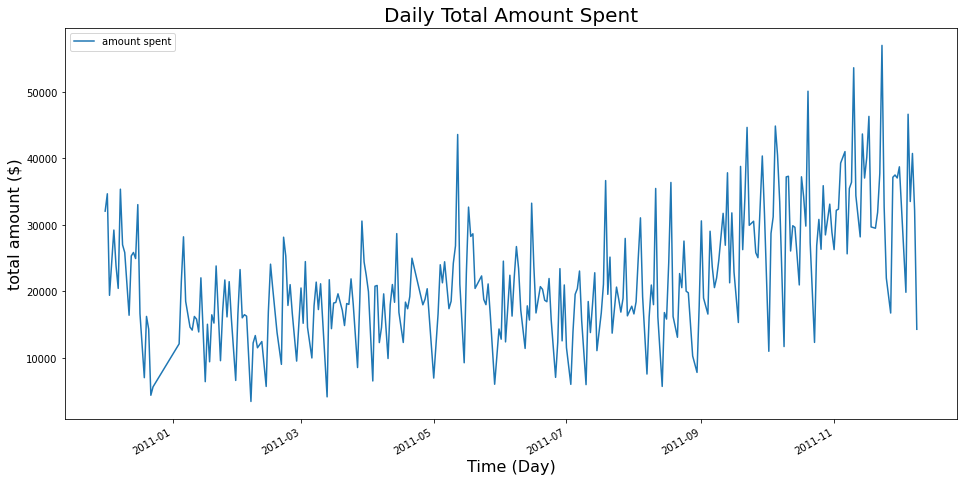

In [34]:
# plot the new dataframe to have a quick look
X = 'ds'
Y = 'y'
Label = "amount spent"
Figsize = (16,8)
Title = "Daily Total Amount Spent"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'total amount ($)'
_fig_plot(df5, X, Y)

In [35]:
# create test dataset, remove last 30 days and keep it as our test
train = df5[:275]
test = df5[275:]

In [ ]:
# let's predict now, we can do it both ways, either on the complete dataset
# to predict on future days or can train on the train dataset and evaluate using test
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality=False,
                  growth='linear', 
#                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8, 
                  yearly_seasonality='auto', 
                  weekly_seasonality='auto', 
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05)
#                  mcmc_samples=0, 
#                  interval_width=0.8, 
#                  uncertainty_samples=1000, 
#                  stan_backend=None)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()